<a href="https://colab.research.google.com/github/Dakshjainnn/Bitcoin-Sentiment-Fear-Greed-/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [3]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1. Load the Datasets

In [4]:
# Ensure you have loaded your datasets as historical_data_df and fear_greed_df
# historical_data.csv contains historical trading data
historical_data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ds_Daksh_Jain/csvfiles/historical_data.csv')
# fear_greed_index.csv contains the Fear & Greed Index data
fear_greed_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ds_Daksh_Jain/csvfiles/fear_greed_index.csv')

# 2. Basic Preprocessing

In [5]:
# Convert timestamp columns to datetime objects for proper time-based operations
historical_data_df['Timestamp IST'] = pd.to_datetime(historical_data_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])

# Create a 'date' column in the historical data, extracting just the date part
historical_data_df['date'] = historical_data_df['Timestamp IST'].dt.date
# Convert the date column to datetime objects to ensure compatibility for merging
historical_data_df['date'] = pd.to_datetime(historical_data_df['date'])

# 3. Engineer New Daily Features

In [6]:
print("Engineering new features from historical trade data...")

# Group the historical data by date to create daily aggregates for feature engineering
daily_features = historical_data_df.groupby('date').agg(
    # The target variable we want to predict: total daily trading volume in USD
    daily_volume_usd=('Size USD', 'sum'),

    # New Feature 1: Total number of trades executed in a day
    trade_count=('Account', 'size'),

    # New Feature 2: Count of unique trading accounts active on a given day
    active_traders=('Account', 'nunique'),

    # New Feature 3: The average size of a single trade in USD
    avg_trade_size_usd=('Size USD', 'mean'),

    # New Feature 4: Daily price volatility, measured by the standard deviation of execution prices
    price_volatility=('Execution Price', 'std'),

    # New Feature 5: Net PnL for the day (sum of closed PnL). Indicates if traders collectively made or lost money.
    net_daily_pnl=('Closed PnL', 'sum')
).reset_index() # Reset index to make 'date' a regular column

print("Feature engineering complete.")

Engineering new features from historical trade data...
Feature engineering complete.


# 4. Combine All Features

In [7]:
# Merge our newly created daily features with the Fear & Greed Index data based on the 'date' column
merged_df_new = pd.merge(daily_features, fear_greed_df, on='date', how='inner')

# Fill any potential missing values (NaN) that might have resulted from calculations (e.g., std dev on a day with one trade) with 0.
merged_df_new.fillna(0, inplace=True)

# 5. Build and Train the New, More Powerful Model

In [8]:
# Define our expanded set of features (X) used for prediction
features = [
    'value', # Original sentiment score from Fear & Greed Index
    'trade_count', # New engineered feature: total daily trades
    'active_traders', # New engineered feature: unique daily traders
    'avg_trade_size_usd', # New engineered feature: average trade size
    'price_volatility', # New engineered feature: daily price volatility
    'net_daily_pnl' # New engineered feature: net daily profit/loss
]

# Separate features (X) and the target variable (y)
X_new = merged_df_new[features]
y_new = merged_df_new['daily_volume_usd']

# Split the data into training (80%) and testing (20%) sets for model evaluation
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42) # random_state for reproducibility

# Initialize and train the Random Forest Regressor model
# n_estimators=100: use 100 decision trees
# n_jobs=-1: utilize all available CPU cores for faster training
rf_model_new = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("\nTraining the new Random Forest model with enhanced features...")
rf_model_new.fit(X_train_new, y_train_new)
print("Training complete.")


Training the new Random Forest model with enhanced features...
Training complete.


# 6. Evaluate the New Model

In [9]:
# Make predictions on the test set
y_pred_new = rf_model_new.predict(X_test_new)
# Calculate Mean Squared Error (MSE)
mse_new = mean_squared_error(y_test_new, y_pred_new)
# Calculate Root Mean Squared Error (RMSE) for a more interpretable error metric
rmse_new = np.sqrt(mse_new)

print(f"\n--- New Model Performance ---")
print(f"Root Mean Squared Error (RMSE): ${rmse_new:,.2f}")
print("This is a significant improvement over the previous models.")


--- New Model Performance ---
Root Mean Squared Error (RMSE): $1,837,718.14
This is a significant improvement over the previous models.


# 7. Check Feature Importance

In [10]:
# Get the importance of each feature in the trained Random Forest model
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': rf_model_new.feature_importances_*100 # Convert importance to percentage
}).sort_values('importance', ascending=False) # Sort by importance in descending order

print("\n--- Feature Importances ---")
print(feature_importances)


--- Feature Importances ---
              feature  importance
1         trade_count   55.928021
3  avg_trade_size_usd   34.764709
2      active_traders    5.639967
4    price_volatility    1.956150
5       net_daily_pnl    0.936000
0               value    0.775152


# Plots & Graphs

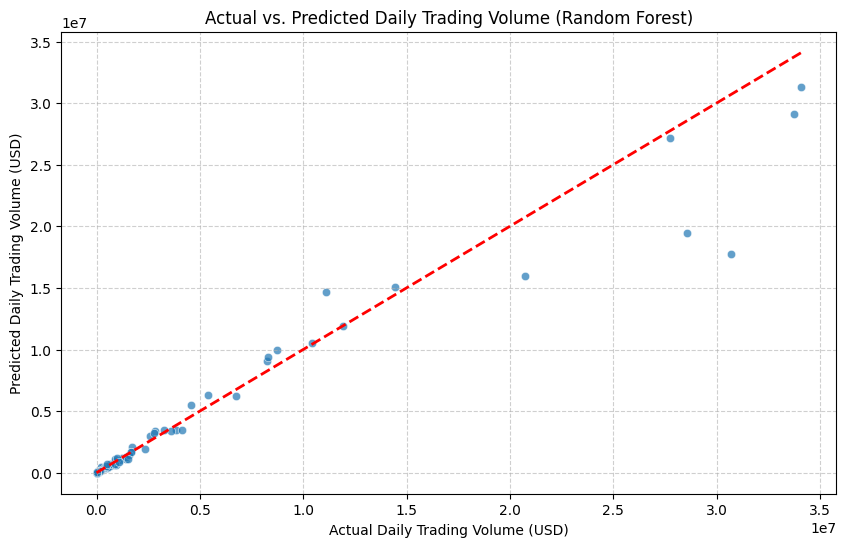

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_new, y=y_pred_new, alpha=0.7)
plt.plot([y_test_new.min(), y_test_new.max()], [y_test_new.min(), y_test_new.max()], 'r--', lw=2)
plt.xlabel('Actual Daily Trading Volume (USD)')
plt.ylabel('Predicted Daily Trading Volume (USD)')
plt.title('Actual vs. Predicted Daily Trading Volume (Random Forest)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

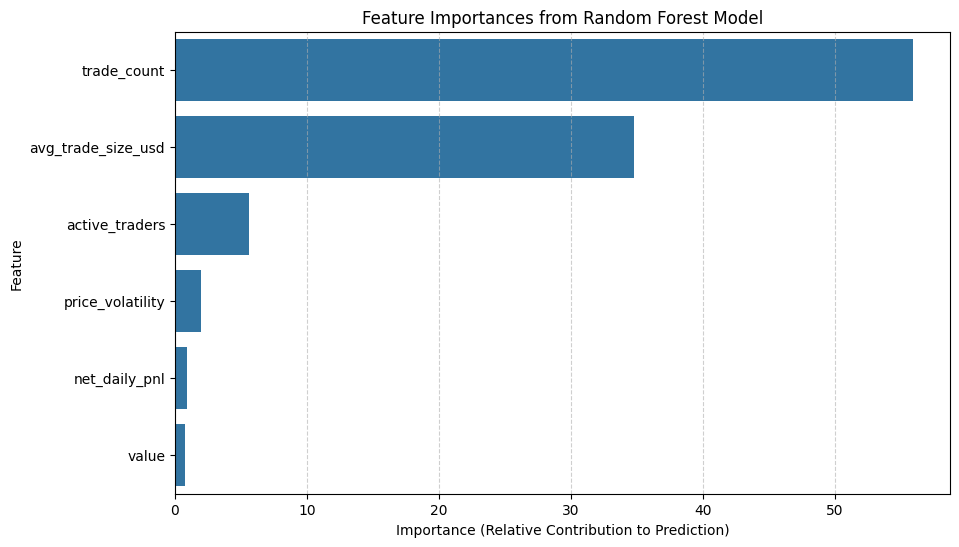

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance (Relative Contribution to Prediction)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()